In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5314048821007248518
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4632277068655432248
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


'2.1.0'

In [2]:
DATA_LIST = os.listdir('../all/train')
DATASET_PATH  = '../all/train'
TEST_DIR =  '../all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


C:\Users\tanzi\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [4]:
# raise NotImplementedError("Build your model based on an architecture of your choice "
#                           "A sample model summary is shown below")

# Implement VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

resNet50V2 = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='None', classes=4)            
resNet50V2.trainable = False

print(resNet50V2.summary())

covid_model = Sequential()
covid_model.add(resNet50V2)
covid_model.add(tf.keras.layers.AveragePooling2D(pool_size=7))
covid_model.add(Flatten())
covid_model.add(Dropout(0.3))
covid_model.add(Dense(256, activation='relu'))
covid_model.add(Dropout(0.2))
covid_model.add(Dense(4, activation='softmax', kernel_initializer='he_normal'))

covid_model.build(input_shape=(224, 224, 3))
covid_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1

In [5]:
# FIT MODEL
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size


def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=DATA_LIST,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

# raise NotImplementedError("Use the model.fit function to train your network")
# covid_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
covid_model.compile(optimizer=Adam(learning_rate=lr_schedule(0)), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
history = None

with tf.device("GPU:0"):
    history = covid_model.fit_generator(generator=train_batches, 
                              steps_per_epoch=STEP_SIZE_TRAIN, 
                              epochs=200,
                              validation_data=(valid_batches),
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callbacks)


22
6
Learning rate:  0.001
Instructions for updating:
Please use Model.fit, which supports generators.


C:\Users\tanzi\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\tanzi\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 21 steps, validate for 5 steps
Learning rate:  0.001
Epoch 1/200


C:\Users\tanzi\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\tanzi\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


21/21 [==============================] - 11s 521ms/step - loss: 1.6089 - accuracy: 0.2961 - val_loss: 1.3779 - val_accuracy: 0.3200
Learning rate:  0.001
Epoch 2/200
21/21 [==============================] - 6s 285ms/step - loss: 1.1075 - accuracy: 0.5534 - val_loss: 1.5768 - val_accuracy: 0.4400
Learning rate:  0.001
Epoch 3/200
21/21 [==============================] - 6s 286ms/step - loss: 0.9194 - accuracy: 0.6165 - val_loss: 2.0715 - val_accuracy: 0.3200
Learning rate:  0.001
Epoch 4/200
21/21 [==============================] - 6s 290ms/step - loss: 0.8273 - accuracy: 0.6143 - val_loss: 2.2460 - val_accuracy: 0.3200
Learning rate:  0.001
Epoch 5/200
21/21 [==============================] - 6s 286ms/step - loss: 0.7953 - accuracy: 0.6571 - val_loss: 2.2151 - val_accuracy: 0.3200
Learning rate:  0.001
Epoch 6/200
21/21 [==============================] - 6s 282ms/step - loss: 0.7635 - accuracy: 0.7039 - val_loss: 2.0888 - val_accuracy: 0.3600
Learning rate:  0.001
Epoch 7/200
21/21 [==

21/21 [==============================] - 6s 278ms/step - loss: 0.5264 - accuracy: 0.7718 - val_loss: 2.6760 - val_accuracy: 0.3000
Learning rate:  0.001
Epoch 51/200
21/21 [==============================] - 6s 280ms/step - loss: 0.4625 - accuracy: 0.8010 - val_loss: 2.6202 - val_accuracy: 0.3000
Learning rate:  0.001
Epoch 52/200
21/21 [==============================] - 6s 283ms/step - loss: 0.5606 - accuracy: 0.7670 - val_loss: 1.5828 - val_accuracy: 0.5400
Learning rate:  0.001
Epoch 53/200
21/21 [==============================] - 6s 285ms/step - loss: 0.5107 - accuracy: 0.7864 - val_loss: 2.7110 - val_accuracy: 0.3400
Learning rate:  0.001
Epoch 54/200
21/21 [==============================] - 6s 274ms/step - loss: 0.5836 - accuracy: 0.7427 - val_loss: 1.9992 - val_accuracy: 0.3800
Learning rate:  0.001
Epoch 55/200
21/21 [==============================] - 6s 281ms/step - loss: 0.4558 - accuracy: 0.8204 - val_loss: 2.0235 - val_accuracy: 0.3400
Learning rate:  0.001
Epoch 56/200
21/2

21/21 [==============================] - 6s 284ms/step - loss: 0.4066 - accuracy: 0.8398 - val_loss: 1.5008 - val_accuracy: 0.5000
Learning rate:  0.0001
Epoch 100/200
21/21 [==============================] - 6s 283ms/step - loss: 0.3961 - accuracy: 0.8204 - val_loss: 1.9669 - val_accuracy: 0.4000
Learning rate:  0.0001
Epoch 101/200
21/21 [==============================] - 6s 280ms/step - loss: 0.4284 - accuracy: 0.8301 - val_loss: 1.8727 - val_accuracy: 0.4200
Learning rate:  0.0001
Epoch 102/200
21/21 [==============================] - 6s 283ms/step - loss: 0.4090 - accuracy: 0.8350 - val_loss: 2.1908 - val_accuracy: 0.3400
Learning rate:  0.0001
Epoch 103/200
21/21 [==============================] - 6s 283ms/step - loss: 0.3759 - accuracy: 0.8447 - val_loss: 1.8913 - val_accuracy: 0.4200
Learning rate:  0.0001
Epoch 104/200
21/21 [==============================] - 6s 282ms/step - loss: 0.4784 - accuracy: 0.7913 - val_loss: 1.9921 - val_accuracy: 0.3400
Learning rate:  0.0001
Epoch 

21/21 [==============================] - 6s 284ms/step - loss: 0.3267 - accuracy: 0.8738 - val_loss: 1.9211 - val_accuracy: 0.4600
Learning rate:  1e-05
Epoch 149/200
21/21 [==============================] - 6s 284ms/step - loss: 0.3751 - accuracy: 0.8204 - val_loss: 1.9247 - val_accuracy: 0.4000
Learning rate:  1e-05
Epoch 150/200
21/21 [==============================] - 6s 286ms/step - loss: 0.3459 - accuracy: 0.8058 - val_loss: 2.1235 - val_accuracy: 0.4000
Learning rate:  1e-05
Epoch 151/200
21/21 [==============================] - 6s 281ms/step - loss: 0.4285 - accuracy: 0.8107 - val_loss: 2.0444 - val_accuracy: 0.4000
Learning rate:  1e-05
Epoch 152/200
21/21 [==============================] - 6s 282ms/step - loss: 0.3858 - accuracy: 0.8592 - val_loss: 2.0542 - val_accuracy: 0.3800
Learning rate:  1e-05
Epoch 153/200
21/21 [==============================] - 6s 285ms/step - loss: 0.4096 - accuracy: 0.8301 - val_loss: 2.1659 - val_accuracy: 0.3800
Learning rate:  1e-05
Epoch 154/20

21/21 [==============================] - 6s 293ms/step - loss: 0.4618 - accuracy: 0.8000 - val_loss: 1.7192 - val_accuracy: 0.3400
Learning rate:  5e-07
Epoch 198/200
21/21 [==============================] - 6s 275ms/step - loss: 0.4043 - accuracy: 0.8398 - val_loss: 1.9753 - val_accuracy: 0.4600
Learning rate:  5e-07
Epoch 199/200
21/21 [==============================] - 7s 322ms/step - loss: 0.4312 - accuracy: 0.7961 - val_loss: 1.7772 - val_accuracy: 0.4800
Learning rate:  5e-07
Epoch 200/200
21/21 [==============================] - 6s 286ms/step - loss: 0.3676 - accuracy: 0.8495 - val_loss: 2.5043 - val_accuracy: 0.3200


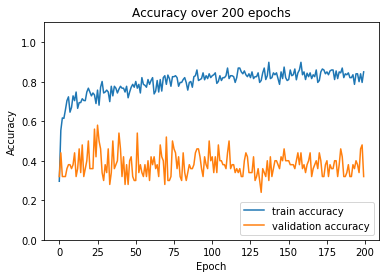

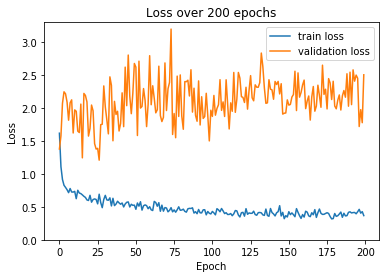

In [6]:
import matplotlib.pyplot as plt

# raise NotImplementedError("Plot the accuracy and the loss during training")

# Accuracy over 40 Epochs
plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy') 
plt.plot(history.history['val_accuracy'], label = 'validation accuracy') 
plt.title('Accuracy over 200 epochs')
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.ylim([0, 1.1]) 
plt.legend(loc='lower right')

# Loss over 40 Epochs
plt.figure()
plt.plot(history.history['loss'], label='train loss') 
plt.plot(history.history['val_loss'], label = 'validation loss') 
plt.title('Loss over 200 epochs')
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.ylim([0, 3.3]) 
plt.legend(loc='upper right')

In [7]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = covid_model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
36/36 [==============================] - 1s 30ms/step - loss: 1.3661 - accuracy: 0.5000
Test loss: 1.366102649882022
Test accuracy: 0.5


Found 270 images belonging to 4 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
270/270 [==============================] - 6s 22ms/step
(270, 256)
(270, 2)


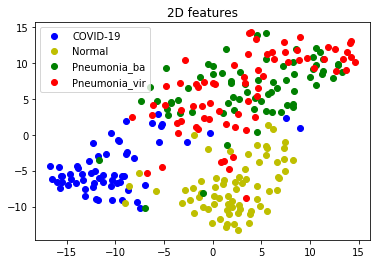

In [8]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=covid_model.input,
                                        outputs=covid_model.get_layer('dense').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")

# raise NotImplementedError("Extract features from the tsne_data_generator and fit a t-SNE model for the features,"
#                           "and plot the resulting 2D features of the four classes.")

outputs = intermediate_layer_model.predict_generator(tsne_eval_generator,270,verbose=1)
print(outputs.shape)
label = tsne_eval_generator.classes
features = TSNE(n_components=2).fit_transform(outputs)
print(features.shape)

covid_x = []
covid_y = []
normal_x = []
normal_y = []
pneumonia_bac_x = []
pneumonia_bac_y = []
pneumonia_vir_x = []
pneumonia_vir_y = []


plt.figure()
for index in range(len(features)):
    if label[index] == 0:
        # COVID: Blue
        covid_x.append(features[index, 0])
        covid_y.append(features[index, 1])        
    elif label[index] == 1:
        # Normal: Yellow
        normal_x.append(features[index, 0])
        normal_y.append(features[index, 1]) 
    elif label[index] == 2:
        # Pneumonia_bac: Green
        pneumonia_bac_x.append(features[index, 0])
        pneumonia_bac_y.append(features[index, 1]) 
    else:
        # Pneumonia_vir: Red
        pneumonia_vir_x.append(features[index, 0])
        pneumonia_vir_y.append(features[index, 1]) 

        
plt.title('2D features')
plt.plot(covid_x, covid_y, 'bo', label="COVID-19")
plt.plot(normal_x, normal_y, 'yo', label="Normal")
plt.plot(pneumonia_bac_x, pneumonia_bac_y, 'go', label="Pneumonia_ba")
plt.plot(pneumonia_vir_x, pneumonia_vir_y, 'ro', label="Pneumonia_vir")
plt.legend(loc='upper left')